Checking consistency...
 - DataFrame IDs: 100
 - Embeddings IDs: 100
 - Attention Weights IDs: 100
Consistency checked.

ProteinDataset Report:
 - Number of samples: 100
 - Number of embeddings: 100
 - Number of attention weights: 100
 - Target column: Class
 - ID column: UniProt IDs
 - Save path: ./OUTPUTS/

Converting embeddings and attention weights to NumPy arrays...
Applying dimensionality reduction using pca...
Epoch 1, Training Loss: 0.6949, Validation Loss: 0.7134, Training Accuracy: 0.5125, Validation Accuracy: 0.3000
Epoch 2, Training Loss: 0.6954, Validation Loss: 0.7133, Training Accuracy: 0.5125, Validation Accuracy: 0.3000
Epoch 3, Training Loss: 0.6932, Validation Loss: 0.7132, Training Accuracy: 0.5125, Validation Accuracy: 0.3000
Epoch 4, Training Loss: 0.6938, Validation Loss: 0.7132, Training Accuracy: 0.5125, Validation Accuracy: 0.3000
Epoch 5, Training Loss: 0.6925, Validation Loss: 0.7132, Training Accuracy: 0.5125, Validation Accuracy: 0.3000


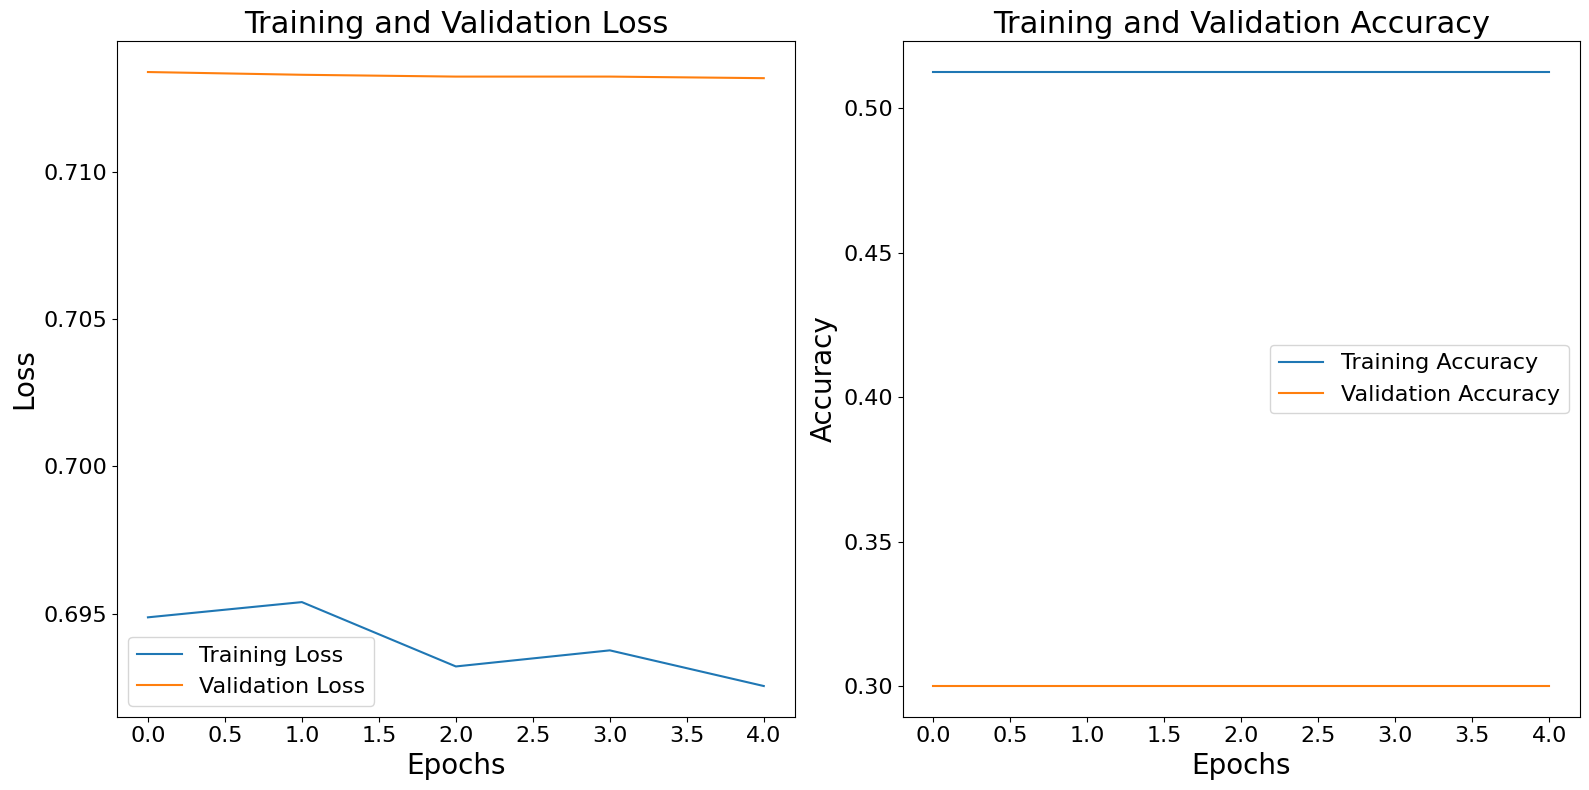

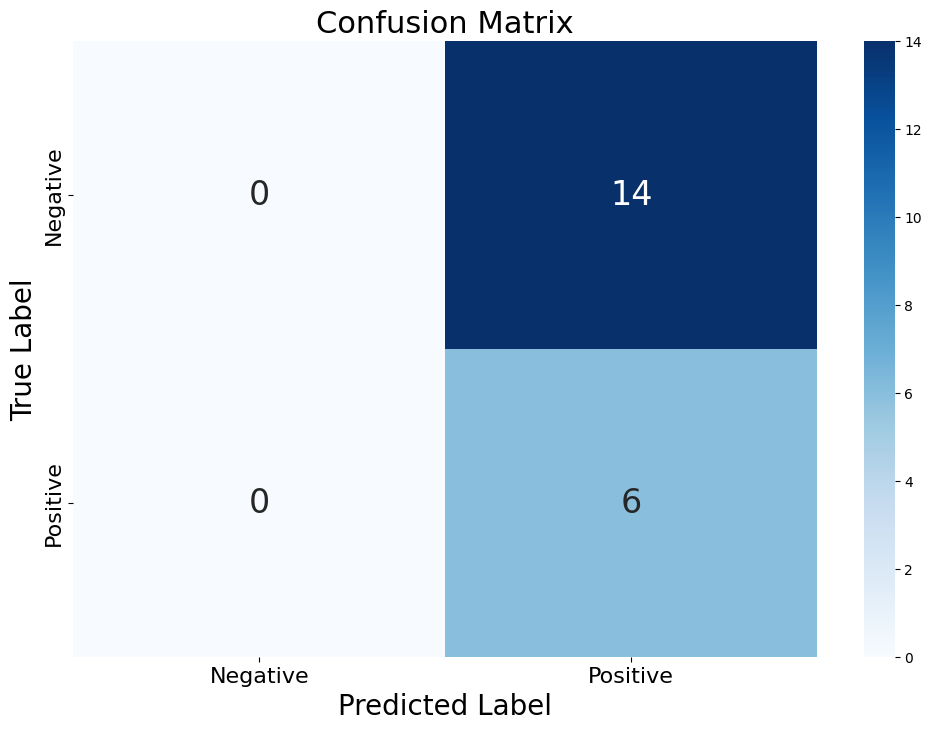


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        14
    Positive       0.30      1.00      0.46         6

    accuracy                           0.30        20
   macro avg       0.15      0.50      0.23        20
weighted avg       0.09      0.30      0.14        20

Especificidad: 0.0000
Estadístico Kappa: 0.0000
✅ ProteinClassifier + Trainer test complete


/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [1]:
# ✅ Test script for ProteinClassifier and Trainer
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

from project_root.dataset.protein_dataset import ProteinDataset
from project_root.dataset.wrapped_protein_dataset import WrappedProteinDataset
from project_root.models.protein_classifier import ProteinClassifier
from project_root.training.trainer import Trainer

# -----------------------------------------
# 🔧 Generate dummy data using ProteinDataset
# -----------------------------------------
ids = [f"P{i:04d}" for i in range(100)]
embedding_dim = 64
attn_shape = (12, 64)

# Create DataFrame
df = pd.DataFrame({
    "UniProt IDs": ids,
    "Class": np.random.randint(0, 2, size=len(ids))
})

# Simulated embeddings and attention weights
embeddings = {id_: np.random.rand(embedding_dim) for id_ in ids}
attention_weights = {id_: np.random.rand(*attn_shape) for id_ in ids}

# Build datasets
protein_dataset = ProteinDataset(df, embeddings, attention_weights, solve_inconsistencies=True)
wrapped_dataset = WrappedProteinDataset(protein_dataset, reduce_method='pca', pca_method='threshold', threshold=0.95)

# -----------------------------------------
# 🧪 Prepare dataloaders
# -----------------------------------------
X = torch.tensor(wrapped_dataset.combined_embeddings_and_attention, dtype=torch.float32)
y = torch.tensor(protein_dataset.get_labels(), dtype=torch.float32)

dataset = TensorDataset(X, y)
split = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split, len(dataset) - split])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# -----------------------------------------
# 🧠 Build and train model
# -----------------------------------------
input_size = X.shape[1]
model_fn = lambda size: ProteinClassifier(
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    input_size=input_size,
    output_size=1,
    num_hidden_layers=3,
    hidden_layers_mode='quadratic_increase'
)

trainer = Trainer(model_class=model_fn)
train_losses, val_losses, train_accs, val_accs = trainer.train_and_validate(train_loader, test_loader, num_epochs=5)

# -----------------------------------------
# 📈 Visualize results and evaluate
# -----------------------------------------
trainer.plot_results(train_losses, val_losses, train_accs, val_accs)
trainer.evaluate_and_plot_confusion_matrix(test_loader)

print("✅ ProteinClassifier + Trainer test complete")
